# Blind source separation, using ICA

The goal of this exercise is to disentangle mixed audio signals into separate tracks (commonly known as "Blind Source Separation"). In contrast with PCA (which uses second order correlations in the data), ICA relies on non-Gaussianities in the distribution. Motivated by this heuristic, we set up a cost function that is in the spirit of minimizing mutual information among the decoded signals. We then perform a gradient descent on that cost function to find the right linear transformation to un-mix the observed signals.


## Intuition about the essence of ICA

_If the signals being superposed are all "sparse" then it will look like the distributions have been superimposed, rather than convolved, since probably only one of the source is switched on at each time instant._ 

What does it mean for a random variable to be sparse, assuming that you're drawing a fixed number of samples from it? It means that the random variable is highly peaked around being "off" and large tails of "on". The essence of ICA is to detect these spikes (or anti-spikes) coming from sparsity/higher moments/non-Gaussianity.

For a given variance, signals that are sharply peaked (sparse) must have long tails (size of tail varies inversely as sparsity/peakedness) and hence significant presence of higher moments. When composing two such distributions together, simultaneously getting extreme samples from both are quite unlikely, which would mean that the distribution of observations will tend to have _spikes_ in the direction of each of the sources! Ultimately, the crux of ICA is about identifying this spikiness (non-Gaussianity) once we've spherically symmetrized the covariance of the distribution!

In spirit, the size of the spikes should be proportional to the size of the higher moments (for distributions which are tailed thinner than Gaussians, the spikes should become gaps aka _anti-spikes_ in the appropriate direction!). As we dial the knob on making the distribution tails fatter or thinner, we should be able to see these spikes changing. When the distributions are exactly Gaussian, the independent directions blend into the the in-between directions, and we get the covariance ellipsoid without any spikes or anti-spikes. The limiting cases look as follows:
1. Most higher moments for a given variance: These must be distributions with power law tails (we could of course make all higher moments infinite). In this case we should clearly see spikes for the composed distribution, once we normalize the variance.
2. Least higher moments for a given variance: This must be the uniform distribution (or could it be the semicircle?). In this case we should clearly see anti-spikes for the composed distribution, once we normalize the variance.

-----

This also makes it clear why our approach will only work for linear transformations. Nonlinear transformations generate higher harmonics (spurious non-Gaussianity). 

An even simpler statement: At every point in signal space, the Jacobian of transformation will affect the PDF and hence the characteristic function. Therefore, we expect the moments to get messed up for any transformation where the Jacobian has a position dependence (i.e. anything but an affine transformation!).


## Mathematical model

Suppose you wish to infer signals $\{s_i\}_{i=1 \ldots k}$ by sensing mixtures $\{x_\alpha\}_{\alpha=1 \ldots n}$. Assume that the mixing transform is linear (with rank greater than the number of sources), and that each of the signals consists samples from an independent distribution $p_\alpha(s_\alpha)$, so that any correlation between observables is from the same signal.
$$x_i = A_i^\alpha s_\alpha \;\; \textrm{such that} \;\; \hat{s}_\alpha = W_\alpha^i x_i$$

$\{s_\alpha\}$ are specified specified only up to a permutation, and a scaling on each of them.

$$p_i(x_i) = p_\alpha(W_\alpha^i x_i) \; \det{(W)}$$

The task is to invert the observables to get the sources. For this, we need to solve for $W_\alpha^i$ which is a set of $k$ vectors in the $n$-dimensional space of observables. Each vector relates to the strength with which each observable couples to each source (that is what it means to have a direction in observable space)

If the set of observables are Gaussian distributed, then all that we can do is find the principal components, but do nothing to pin down the sources! This can happen in two cases:
1. $p_\alpha(s_\alpha)$ is Gaussian for more than one signal.
2. Several signals being combined (added) into each observable leads to "erasure" of moments via the central limit theorem.

*If we are not beset by either of those problems, and that we can rely on the higher moments of those distributions making their presence felt in all the final combinations.*

The mixing transformation can be decomposed as $A \equiv V^T D U$. This implies that, _assuming_ that $s_\alpha$ is white (no second order correlations), we can get $D^2$ and $U$ by diagonalizing $\Sigma = \langle x_i {x_i}^T \rangle$. (This is equivalent to assigning all the scaling in the 2nd order correlations to the mixing matrix, rather than the initial distribution.)

After that, we only need to find a rotation $V$ which optimizes statistical independence between the estimated sources. There are multiple strategies based on which proxy measure for independence we would like to use. The "Right Way" would be to maximize negentropy $$\mathcal{L} = \max_{V} \sum_\alpha H[s_\alpha \equiv V_\alpha^i {\chi}_i]$$

There are two ways to intuit what this means:
1. Finding the rotated basis which maximizes the non-Gaussianity of the data (since the Gaussian has most entropy, and thereby least mutual information)
2. Supposedly, equivalent to maximizing the log-likelihood of the observed data, under the assumption that the data arose from statistically independent sources.


**Minimizing the mutual information is akin to finding the directions of maximum negentropy/nongaussianity, iff the sources can be assumed to be uncorrelated.**

Extremely clear explanation in [Johnathon Shlens, ICA tutorial](https://arxiv.org/abs/1404.2986)

## So what do we do? (Procedure)

Each track is along a column of the source matrix, so we can right multiply by the mixing transformation.
We "zero-shift" and normalize signals, to ensure that the loudest signals do not dominate and leave artifacts. We then "whiten" them by removing all second order correlations. 

*Whitening*: Normalizing the covariance in each direction is called whitening. Imagine that the eigenvalues of the covariance matrix as analogous to a frequency spectrum (different directions are not exactly like different frequencies, just different linearly independent components). Then making the spectrum _flat_ is akin to making the spectrum _whiter_ (no frequency biases).

We then perform gradient descent on the following cost function:
$$$$
The updating step looks as follows (where the function $\left[ 1 - 2\sigma(t) \right]$ is applied to each element of $y$)
$$V = V + \eta \left[ \mathbb{1} + \left[ (1 - 2 \sigma) \cdot{(y)} \right] \;\;\; y^T V \right]$$



In [1]:
import numpy as np
import numpy.linalg as nl
import scipy as sp
import scipy.io as sio
import matplotlib.pyplot as plt

In [2]:
np.random.seed(2017) # for reproducibility

In [3]:
from IPython.display import Audio
import scipy.io.wavfile  as spw

In [4]:
from sklearn.decomposition import FastICA, PCA
def findICA(mixedSources,nComp):
    """Each track/source is a column of rows"""
    ica = FastICA(n_components=nComp)
    S = ica.fit_transform(mixedSources)  # Reconstruct signals
    A = ica.mixing_  # Get estimated mixing matrix
    return A

In [5]:
def correlate(A,B):
    return np.dot(normalize(meanSubtract(A,ax=1),ax=1),normalize(meanSubtract(B,ax=1),ax=1).transpose())

In [6]:
def sourcePlots(origTracks, deducedTracks):
    length = deducedTracks.shape[0]
    fig, axarr = plt.subplots(1,length,figsize=(16,3))
    
    for i in range(0,length):
        axarr[i].plot(deducedTracks[i,:])
        axarr[i].plot(origTracks[i,:])
        axarr[i].set_ylim(-0.02,0.02)
    
    plt.show()

In [7]:
def sigmoid(t):
    return 1/(1+np.exp(-t))

def improve(V,lRate,nSteps,x):
    Vnew = V
    
    # Use whitened signal
    xw = whiten(x,1)
    
    # Enforce orthogonality for V?
    # This is a python for loop. Could this be made faster?
    for i in range(1,nSteps):
        # Old painful form, also signals were column-wise rather than row-wise
        #gradCostFn = np.dot(x.transpose(),(1-2*sigmoid(np.dot(x,V)))) + nl.inv(V)
        
        # New better form
        yy = np.dot(Vnew,xw)
        gradCostFn = np.eye(V.shape[0]) + np.dot(np.dot((1-2*sigmoid(yy)),yy.transpose()),Vnew)
        # Assuming V is square.. otherwise what to do with the identity matrix? Will it be truncated??
        
        # Should this gradient be normalized by the length of the batch wouldn't that be sensible??
    
        Vnew = Vnew + (lRate/x.shape[1])*gradCostFn # Hill climbing for max likelihood
        #Vnew = Vnew/nl.norm(Vnew,axis=1) # Too expensive for doing every step?
    
    return Vnew

In [8]:
# def improve(V,lRate,nSteps,x):
#     Vnew = V
#     # Enforce orthogonality for V?
#     # This is a python for loop. Could this be made faster?
#     for i in range(1,nSteps):
#         gradCostFn = np.dot(x.transpose(),(1-2*sigmoid(np.dot(x,V)))) + nl.inv(V)
#         Vnew = Vnew + lRate*gradCostFn/x.shape[0] # Hill climbing for max likelihood
#         Vnew = Vnew/nl.norm(Vnew,axis=0)
    
#     return Vnew

In [9]:
def normalize(foo,ax):
    return foo/nl.norm(foo,axis=ax).reshape(foo.shape[0],1)

def meanSubtract(foo,ax):
    return foo-np.mean(foo,axis=ax).reshape(foo.shape[0],1)

def whiten(X,scale):
    "Different rows of X correspond to different signals"
    C = np.cov(X) # C is a symmetric matrix
    U, D, V = nl.svd(C)
    Xw = np.dot(V,X)*np.sqrt(scale/D).reshape(X.shape[0],1)
    return Xw

In [10]:
def testWhiten():
    return np.cov(whiten(np.random.rand(3,10),1))

testWhiten()

array([[  1.00000000e+00,   1.97372982e-16,   2.46716228e-17],
       [  1.97372982e-16,   1.00000000e+00,   7.40148683e-17],
       [  2.46716228e-17,   7.40148683e-17,   1.00000000e+00]])

In [11]:
def outliers(X,threshold=1):
    return X[np.where(nl.norm(whiten(X,1),axis=1) > threshold)[0]]

def inliers(X,threshold=1):
    return X[np.where(nl.norm(whiten(X,1),axis=1) < threshold)[0]]

In [12]:
# data = sio.loadmat('sounds.mat')
# origSources = data['sounds'][0:3].transpose()
# samples=np.arange(30000,40000)
# origSources=origSources[samples]

## Initializing the problem (mixing sources)

In [13]:
data = sio.loadmat('sounds.mat')
origSources = data['sounds']
#samples=np.arange(30000,35000)
samples=np.arange(0,44000)
origSources=normalize(meanSubtract(origSources[2:5,samples],1),1) # Normalizing signals
origSources.shape

(3, 44000)

In [14]:
Audio(origSources[2,:],rate=11025)

In [15]:
# Each track/source is a column of rows
mixers = 0.5*np.random.rand(3,3)
#mixers = mixers/nl.norm(mixers,axis=0)
mixedSources = np.dot(mixers,origSources)
mixedSources.shape

(3, 44000)

In [16]:
Audio(mixedSources[1,:],rate=11025)

## Searching for the de-mixing transformation

In [17]:
Vinit = np.random.random(size=mixers.shape)
Vspl = Vinit
Vinit

array([[ 0.36062923,  0.92020863,  0.91342656],
       [ 0.26964018,  0.30545812,  0.01550305],
       [ 0.53764777,  0.66815524,  0.45601423]])

In [18]:
def batchLearn(learnRate,nIter,nBatch):
    batch = np.random.choice(mixedSources.shape[1],nBatch) # Can we select more intelligently
    return improve(Vspl,learnRate,nIter,mixedSources[:,batch])

In [19]:
Vspl=batchLearn(0.1,100000,10000)
Vspl=batchLearn(0.01,100000,10000)
#Vspl=batchLearn(0.01,100000,10000)

deducedSources_mine = normalize(np.dot(Vspl,mixedSources),1)

In [20]:
100*np.dot(Vspl,mixers)

array([[ 0.08257262,  0.24801794,  2.06569446],
       [ 1.33661432,  2.05866491,  2.72739292],
       [ 1.19418259,  0.11189249,  1.81805817]])

In [21]:
def block4(batch):
    sourcePlots(origTracks=origSources[:,batch],deducedTracks=np.dot(np.diag([1,1,1]),deducedSources_mine[[1,0,2]][:,batch])) 

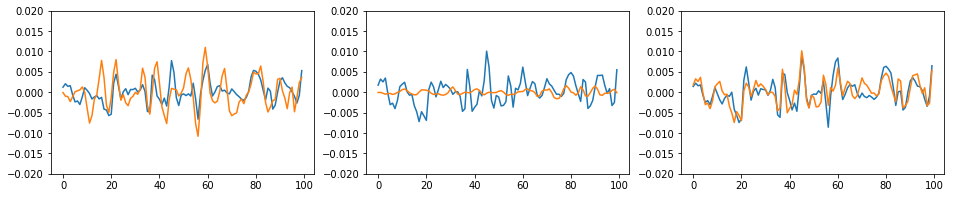

In [22]:
block4(np.arange(27300,27400))

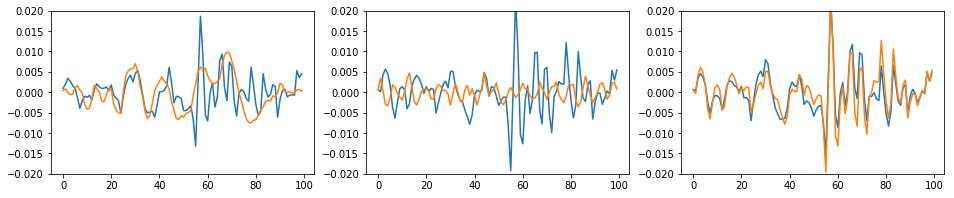

In [23]:
block4(np.arange(2700,2800))

## Comparing with sklearn

In [24]:
mm=findICA(mixedSources=mixedSources[0:10000].transpose(),nComp=3)

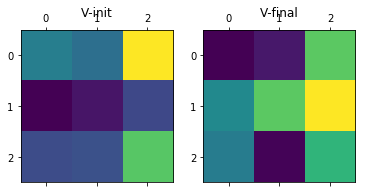

In [25]:
def block5():
    fig, axarr = plt.subplots(1,2,figsize=(6,6))
    
    #axarr[0,0].matshow(np.abs(mixers))
    #axarr[0,1].matshow(np.abs(np.dot(nl.inv(mm),mixers)))
    axarr[0].matshow(np.abs(np.dot(Vinit,mixers)))
    axarr[0].set_title("V-init")
    axarr[1].matshow(np.abs(np.dot(Vspl,mixers)))
    axarr[1].set_title("V-final")
    
    plt.show()

block5()

In [26]:
Audio(deducedSources_mine[0,:],rate=11025)

In [27]:
correlate(deducedSources_mine,origSources)

array([[ 0.0454777 ,  0.12329943,  0.99218524],
       [ 0.36012768,  0.55801478,  0.74854847],
       [ 0.55219881,  0.04577087,  0.83653902]])

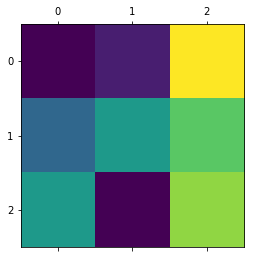

In [28]:
plt.matshow(np.abs(correlate(deducedSources_mine,origSources)))
plt.show()